In [35]:
import cv2
import torch
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import torchvision as tv
from functools import reduce
import operator
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.ops import SqueezeExcitation as SE
import time
import gc
import pandas as pd

In [2]:
train_ind = [f"{i}" if i >= 10 else f"0{i}" for i in range(1, 21)]

In [3]:
train_cond = lambda x: reduce(operator.or_, [x.startswith(f"person{i}") for i in train_ind])
test_cond = lambda x: not reduce(operator.or_, [x.startswith(f"person{i}") for i in train_ind]) 

In [4]:
classes_dict = {s: i for (i, s) in enumerate(os.listdir("./KTH_Dataset_tensors"))}

In [6]:
classes_dict

{'boxing': 0,
 'handclapping': 1,
 'handwaving': 2,
 'jogging': 3,
 'running': 4,
 'walking': 5}

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 4060 Laptop GPU'

In [9]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, is_train = True):
        cond = train_cond if is_train else test_cond
        data_path = "./KTH_Dataset_tensors"
        self.data = []
        self.classes = []
        if is_train:
            self.transforms = tv.transforms.Compose([lambda x: x.permute(2, 0, 1) / 255, tv.transforms.Grayscale(), tv.transforms.Resize((128, 128)), 
                                                     tv.transforms.RandomRotation(degrees = 10),
                                                    tv.transforms.RandomHorizontalFlip(p=0.3)])
        else:
            self.transforms = tv.transforms.Compose([lambda x: x.permute(2, 0, 1) / 255, tv.transforms.Grayscale(), tv.transforms.Resize((128, 128))])
        for directory in (os.listdir(data_path)):
            for video in tqdm(os.listdir(os.path.join(data_path, directory))):
                if cond(video) & (video.split('.')[0].split('_')[-1] <= '128'):
                    self.data.append(os.path.join(data_path, directory, video))
                    self.classes.append(classes_dict[directory])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        t = self.transforms(torch.load(self.data[i]))
        return t, self.classes[i]

In [10]:
train = MyDataset(True)
test = MyDataset(False)

100%|████████████████████████████████████████████████████████████████████████| 65795/65795 [00:00<00:00, 387369.87it/s]


In [11]:
trainloader = torch.utils.data.DataLoader(train, batch_size = 32, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = 32)

In [12]:
class HARNet(nn.Module):
    def __init__(self):
        super(HARNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3), nn.GroupNorm(2, 32), nn.LeakyReLU(), SE(32, 32))
        self.conv2 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3), nn.GroupNorm(4, 32))
        self.conv3 = nn.Sequential(nn.Conv2d(1, 32, kernel_size = 3), nn.GroupNorm(8, 32))
        self.op1 = nn.Sequential(nn.LeakyReLU(), SE(32, 32))
        self.op2 = nn.Sequential(nn.LeakyReLU(), SE(32, 32))
        self.classifier = nn.Sequential(nn.Linear(32 * 126 * 126, 126), nn.LeakyReLU(), nn.Linear(126, 6))
        

    def forward(self, input_):
        x = self.conv1(input_)
        x =  self.conv2(input_) + x
        x = self.op1(x)
        x = self.conv3(input_) + x
        x = self.op2(x)
        x = self.classifier(x.reshape(-1, 32 * 126 * 126))
        return x

In [13]:
model = HARNet()

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.8)

In [14]:
def accuracy(model, test_data):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in (pbar := tqdm(test_data)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            accuracy += torch.sum(torch.argmax(model(inputs), dim = 1) == labels.to(device))
            pbar.set_description(f'num_of_right_preds : {accuracy} ')
    model.train()
    return accuracy / (len(test_data) * test_data.batch_size)

In [15]:
epochs = 100
acc_test = []
acc_train = []

In [16]:
model.to(device)
for epoch in range(epochs):
    running_loss = 0
    start_time = time.time()
    for inputs, labels in (pbar := tqdm(trainloader)):
        inputs = inputs.squeeze(0).to(device)
        labels = labels.squeeze(0).to(device)
        outputs = model(inputs).squeeze(0)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_item = loss.item()
        running_loss += loss_item
        pbar.set_description(f'loss : {loss_item} ')
    end_time = time.time()
    scheduler.step()
   
    print('epoch: ', epoch, 'loss: ', running_loss / len(trainloader), 'time: ', end_time - start_time)
    if (epoch + 1) % 10 == 0:
        accuracy_test = accuracy(model, testloader)
        accuracy_train = accuracy(model, trainloader)
        acc_train.append(accuracy_train.item())
        acc_test.append(accuracy_test.item())
        torch.save(model.state_dict(), f'model_{epoch}.pth')
        print(accuracy_test, accuracy_train)

loss : 1.6017570495605469 : 100%|████████████████████████████████████████████████████| 530/530 [00:58<00:00,  9.06it/s]


epoch:  0 loss:  1.8586929512473773 time:  58.49408984184265


loss : 1.155811071395874 : 100%|█████████████████████████████████████████████████████| 530/530 [00:53<00:00,  9.92it/s]


epoch:  1 loss:  1.3309994144259758 time:  53.44974207878113


loss : 1.0469352006912231 : 100%|████████████████████████████████████████████████████| 530/530 [00:53<00:00,  9.94it/s]


epoch:  2 loss:  1.2039646072207757 time:  53.316977977752686


loss : 1.2078841924667358 : 100%|████████████████████████████████████████████████████| 530/530 [00:52<00:00, 10.01it/s]


epoch:  3 loss:  1.1457732484025775 time:  52.94575047492981


loss : 1.178679347038269 : 100%|█████████████████████████████████████████████████████| 530/530 [00:55<00:00,  9.55it/s]


epoch:  4 loss:  1.0959997835024349 time:  55.512818574905396


loss : 0.9833002686500549 : 100%|████████████████████████████████████████████████████| 530/530 [00:53<00:00,  9.96it/s]


epoch:  5 loss:  1.0546893414461387 time:  53.196178674697876


loss : 1.029656171798706 : 100%|█████████████████████████████████████████████████████| 530/530 [00:54<00:00,  9.81it/s]


epoch:  6 loss:  1.0203908498557108 time:  54.014240741729736


loss : 0.6875114440917969 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.21it/s]


epoch:  7 loss:  0.9938203799274733 time:  51.88761639595032


loss : 1.0532981157302856 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  8 loss:  0.9566850612748344 time:  51.44798731803894


loss : 0.7273820042610168 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.21it/s]


epoch:  9 loss:  0.9338698767266184 time:  51.92667627334595


num_of_right_preds : 10219 : 100%|███████████████████████████████████████████████████| 530/530 [00:34<00:00, 15.51it/s]


tensor(0.4102, device='cuda:0') tensor(0.6025, device='cuda:0')


loss : 0.9536857008934021 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.38it/s]


epoch:  10 loss:  0.9034620007254043 time:  51.07350397109985


loss : 0.4865328371524811 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.20it/s]


epoch:  11 loss:  0.8734435098913481 time:  51.972208976745605


loss : 1.2869679927825928 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.21it/s]


epoch:  12 loss:  0.8573413517115251 time:  51.91122388839722


loss : 0.7416568994522095 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.24it/s]


epoch:  13 loss:  0.8312504175698983 time:  51.736428022384644


loss : 0.7964432835578918 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  14 loss:  0.8159949049634754 time:  51.44816040992737


loss : 1.0932949781417847 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.36it/s]


epoch:  15 loss:  0.7979464074350753 time:  51.173959493637085


loss : 0.8615131378173828 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.43it/s]


epoch:  16 loss:  0.7753155963600806 time:  50.836445331573486


loss : 0.4264899790287018 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.54it/s]


epoch:  17 loss:  0.7522652365689008 time:  50.29929161071777


loss : 0.7294575572013855 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.53it/s]


epoch:  18 loss:  0.7331108193914845 time:  50.32681751251221


loss : 0.6080492734909058 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.40it/s]


epoch:  19 loss:  0.719244894610261 time:  50.972708225250244


num_of_right_preds : 11933 : 100%|███████████████████████████████████████████████████| 530/530 [00:32<00:00, 16.36it/s]


tensor(0.4006, device='cuda:0') tensor(0.7036, device='cuda:0')


loss : 0.7151757478713989 : 100%|████████████████████████████████████████████████████| 530/530 [00:48<00:00, 10.84it/s]


epoch:  20 loss:  0.6914783372069305 time:  48.907395124435425


loss : 1.0713683366775513 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.63it/s]


epoch:  21 loss:  0.6794529877181323 time:  49.853145360946655


loss : 0.6569237112998962 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.69it/s]


epoch:  22 loss:  0.6679157048463822 time:  49.56476378440857


loss : 0.6884283423423767 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.71it/s]


epoch:  23 loss:  0.656211558040583 time:  49.47406458854675


loss : 0.7119104266166687 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.69it/s]


epoch:  24 loss:  0.6415643003189339 time:  49.576568603515625


loss : 0.7167404294013977 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  25 loss:  0.6276750451551294 time:  51.461172103881836


loss : 0.3506004810333252 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.37it/s]


epoch:  26 loss:  0.6178306762902241 time:  51.129258155822754


loss : 0.681768536567688 : 100%|█████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.28it/s]


epoch:  27 loss:  0.6070027866453495 time:  51.572205781936646


loss : 0.6207243800163269 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.33it/s]


epoch:  28 loss:  0.5907988746211214 time:  51.30785799026489


loss : 0.6660820245742798 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.33it/s]


epoch:  29 loss:  0.5837819264182504 time:  51.31196093559265


num_of_right_preds : 12450 : 100%|███████████████████████████████████████████████████| 530/530 [00:32<00:00, 16.10it/s]


tensor(0.3853, device='cuda:0') tensor(0.7341, device='cuda:0')


loss : 0.32746508717536926 : 100%|███████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.51it/s]


epoch:  30 loss:  0.5672279351724768 time:  50.43062877655029


loss : 0.5783019661903381 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.54it/s]


epoch:  31 loss:  0.5580186672930447 time:  50.272334814071655


loss : 0.6170374155044556 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.55it/s]


epoch:  32 loss:  0.5489802974574971 time:  50.2507758140564


loss : 0.45328521728515625 : 100%|███████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.53it/s]


epoch:  33 loss:  0.5387812304046918 time:  50.322614431381226


loss : 0.3759291470050812 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.47it/s]


epoch:  34 loss:  0.5254301757745024 time:  50.63747048377991


loss : 0.8750402331352234 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.65it/s]


epoch:  35 loss:  0.5188165714437107 time:  49.76216268539429


loss : 0.5653614401817322 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.71it/s]


epoch:  36 loss:  0.518374299665667 time:  49.4651563167572


loss : 0.5781742930412292 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.71it/s]


epoch:  37 loss:  0.506267963546627 time:  49.4754376411438


loss : 0.3653737008571625 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.64it/s]


epoch:  38 loss:  0.5011098117198585 time:  49.81516623497009


loss : 0.5226972103118896 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.68it/s]


epoch:  39 loss:  0.48905316515351244 time:  49.62814140319824


num_of_right_preds : 14035 : 100%|███████████████████████████████████████████████████| 530/530 [00:30<00:00, 17.63it/s]


tensor(0.3979, device='cuda:0') tensor(0.8275, device='cuda:0')


loss : 0.6294189095497131 : 100%|████████████████████████████████████████████████████| 530/530 [00:48<00:00, 10.85it/s]


epoch:  40 loss:  0.47638997621131396 time:  48.86163067817688


loss : 0.511320948600769 : 100%|█████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.66it/s]


epoch:  41 loss:  0.4670469604010852 time:  49.724451303482056


loss : 0.2922991216182709 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.67it/s]


epoch:  42 loss:  0.4580104802577001 time:  49.67661428451538


loss : 0.5399813652038574 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.80it/s]


epoch:  43 loss:  0.46076337321186966 time:  49.09347200393677


loss : 0.6551614999771118 : 100%|████████████████████████████████████████████████████| 530/530 [00:48<00:00, 10.87it/s]


epoch:  44 loss:  0.4540828430427695 time:  48.77160334587097


loss : 0.35106298327445984 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.74it/s]


epoch:  45 loss:  0.43940398352888393 time:  49.327239990234375


loss : 0.3992568552494049 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.65it/s]


epoch:  46 loss:  0.4358182827256761 time:  49.75317931175232


loss : 0.33747532963752747 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.61it/s]


epoch:  47 loss:  0.4330804248182279 time:  49.97568154335022


loss : 0.12449251115322113 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.65it/s]


epoch:  48 loss:  0.4237893302485628 time:  49.751583099365234


loss : 0.4773807227611542 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.64it/s]


epoch:  49 loss:  0.4251520986545761 time:  49.80562424659729


num_of_right_preds : 14505 : 100%|███████████████████████████████████████████████████| 530/530 [00:29<00:00, 17.99it/s]


tensor(0.4067, device='cuda:0') tensor(0.8552, device='cuda:0')


loss : 0.12733756005764008 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.80it/s]


epoch:  50 loss:  0.4068006660297232 time:  49.075480222702026


loss : 0.6424552202224731 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.63it/s]


epoch:  51 loss:  0.40067821198476933 time:  49.85226273536682


loss : 0.2765190303325653 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.66it/s]


epoch:  52 loss:  0.3958662864172234 time:  49.741947412490845


loss : 0.11878473311662674 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.65it/s]


epoch:  53 loss:  0.39464008098222175 time:  49.74520778656006


loss : 0.25343355536460876 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.64it/s]


epoch:  54 loss:  0.3855718398431562 time:  49.793227672576904


loss : 0.2697095572948456 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.61it/s]


epoch:  55 loss:  0.3838547025649053 time:  49.948753356933594


loss : 0.12683477997779846 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.63it/s]


epoch:  56 loss:  0.36906159967184066 time:  49.85841727256775


loss : 0.4025283455848694 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.63it/s]


epoch:  57 loss:  0.3685124326427028 time:  49.84661841392517


loss : 0.19540290534496307 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.64it/s]


epoch:  58 loss:  0.3635752763388292 time:  49.81072688102722


loss : 0.5525004863739014 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.67it/s]


epoch:  59 loss:  0.36085545656816015 time:  49.669182777404785


num_of_right_preds : 14518 : 100%|███████████████████████████████████████████████████| 530/530 [00:31<00:00, 16.75it/s]


tensor(0.4255, device='cuda:0') tensor(0.8560, device='cuda:0')


loss : 0.056518588215112686 : 100%|██████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.60it/s]


epoch:  60 loss:  0.3539363845690804 time:  49.9792377948761


loss : 0.24794086813926697 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.62it/s]


epoch:  61 loss:  0.3458456680881527 time:  49.890382051467896


loss : 0.6925053596496582 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.62it/s]


epoch:  62 loss:  0.3415766258565885 time:  49.92767596244812


loss : 0.3959224820137024 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.62it/s]


epoch:  63 loss:  0.34089108982457306 time:  49.88823890686035


loss : 0.4388379156589508 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.37it/s]


epoch:  64 loss:  0.33485745961936014 time:  51.10875725746155


loss : 0.1797076016664505 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  65 loss:  0.3336145522178344 time:  51.44618344306946


loss : 0.08481262624263763 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.28it/s]


epoch:  66 loss:  0.3250347803223808 time:  51.54440450668335


loss : 0.49943071603775024 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.32it/s]


epoch:  67 loss:  0.3253863539195286 time:  51.35916090011597


loss : 0.3104143738746643 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  68 loss:  0.3230631728639018 time:  51.44499444961548


loss : 0.16692496836185455 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.30it/s]


epoch:  69 loss:  0.3166923511703059 time:  51.478373527526855


num_of_right_preds : 15068 : 100%|███████████████████████████████████████████████████| 530/530 [00:34<00:00, 15.57it/s]


tensor(0.4143, device='cuda:0') tensor(0.8884, device='cuda:0')


loss : 0.507722795009613 : 100%|█████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.48it/s]


epoch:  70 loss:  0.31138165265602885 time:  50.56213736534119


loss : 0.7659949660301208 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.35it/s]


epoch:  71 loss:  0.3119246652666128 time:  51.19268774986267


loss : 0.16298320889472961 : 100%|███████████████████████████████████████████████████| 530/530 [00:53<00:00,  9.86it/s]


epoch:  72 loss:  0.3066011327336419 time:  53.764341831207275


loss : 0.22406204044818878 : 100%|███████████████████████████████████████████████████| 530/530 [00:55<00:00,  9.54it/s]


epoch:  73 loss:  0.3045743594473263 time:  55.53764367103577


loss : 0.4030441641807556 : 100%|████████████████████████████████████████████████████| 530/530 [00:54<00:00,  9.75it/s]


epoch:  74 loss:  0.30559923124482047 time:  54.382291316986084


loss : 0.030555669218301773 : 100%|██████████████████████████████████████████████████| 530/530 [00:56<00:00,  9.45it/s]


epoch:  75 loss:  0.2960967803409077 time:  56.08418083190918


loss : 0.41324400901794434 : 100%|███████████████████████████████████████████████████| 530/530 [00:52<00:00, 10.14it/s]


epoch:  76 loss:  0.2957323450806006 time:  52.24630641937256


loss : 0.35550588369369507 : 100%|███████████████████████████████████████████████████| 530/530 [00:52<00:00, 10.11it/s]


epoch:  77 loss:  0.2966053099705363 time:  52.428855895996094


loss : 0.18096624314785004 : 100%|███████████████████████████████████████████████████| 530/530 [00:52<00:00, 10.13it/s]


epoch:  78 loss:  0.29127440621268075 time:  52.302637577056885


loss : 0.18637783825397491 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.21it/s]


epoch:  79 loss:  0.29141675887523955 time:  51.920931577682495


num_of_right_preds : 15353 : 100%|███████████████████████████████████████████████████| 530/530 [00:35<00:00, 15.05it/s]


tensor(0.4233, device='cuda:0') tensor(0.9052, device='cuda:0')


loss : 0.4626271426677704 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.27it/s]


epoch:  80 loss:  0.27917933029667386 time:  51.62696123123169


loss : 0.0946737676858902 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.22it/s]


epoch:  81 loss:  0.27941486825639344 time:  51.85667872428894


loss : 0.17273272573947906 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.23it/s]


epoch:  82 loss:  0.27677703161003453 time:  51.81794357299805


loss : 0.29613208770751953 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.22it/s]


epoch:  83 loss:  0.2747991830672858 time:  51.853458404541016


loss : 0.25002437829971313 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.24it/s]


epoch:  84 loss:  0.2722781056924811 time:  51.76460337638855


loss : 0.08008026331663132 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.29it/s]


epoch:  85 loss:  0.2752555270239992 time:  51.51200461387634


loss : 0.23766645789146423 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.32it/s]


epoch:  86 loss:  0.27203726528107 time:  51.350916385650635


loss : 0.37807366251945496 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.33it/s]


epoch:  87 loss:  0.2643016815888432 time:  51.295531034469604


loss : 0.5731015801429749 : 100%|████████████████████████████████████████████████████| 530/530 [00:48<00:00, 10.93it/s]


epoch:  88 loss:  0.2654521610939278 time:  48.48093008995056


loss : 0.497605562210083 : 100%|█████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.47it/s]


epoch:  89 loss:  0.26860916475361246 time:  50.600743770599365


num_of_right_preds : 15539 : 100%|███████████████████████████████████████████████████| 530/530 [00:35<00:00, 14.79it/s]


tensor(0.4065, device='cuda:0') tensor(0.9162, device='cuda:0')


loss : 0.0996975526213646 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.32it/s]


epoch:  90 loss:  0.2625768423994195 time:  51.3638756275177


loss : 0.0827983021736145 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.35it/s]


epoch:  91 loss:  0.2616726143320776 time:  51.20744442939758


loss : 0.3914085030555725 : 100%|████████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.35it/s]


epoch:  92 loss:  0.25618643389557894 time:  51.19930171966553


loss : 0.30212101340293884 : 100%|███████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.43it/s]


epoch:  93 loss:  0.25335889881793056 time:  50.81832504272461


loss : 0.2858203053474426 : 100%|████████████████████████████████████████████████████| 530/530 [00:50<00:00, 10.40it/s]


epoch:  94 loss:  0.25130496833403154 time:  50.962629318237305


loss : 0.22717420756816864 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.29it/s]


epoch:  95 loss:  0.25347203719868977 time:  51.51729083061218


loss : 0.16978797316551208 : 100%|███████████████████████████████████████████████████| 530/530 [00:51<00:00, 10.38it/s]


epoch:  96 loss:  0.24992162700531617 time:  51.04244303703308


loss : 0.051445603370666504 : 100%|██████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.64it/s]


epoch:  97 loss:  0.25324802492868226 time:  49.822887897491455


loss : 0.06061052531003952 : 100%|███████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.66it/s]


epoch:  98 loss:  0.2464914119187391 time:  49.7185218334198


loss : 0.2379346340894699 : 100%|████████████████████████████████████████████████████| 530/530 [00:49<00:00, 10.62it/s]


epoch:  99 loss:  0.24321326706207025 time:  49.903517723083496


num_of_right_preds : 15522 : 100%|███████████████████████████████████████████████████| 530/530 [00:29<00:00, 17.93it/s]


tensor(0.4153, device='cuda:0') tensor(0.9152, device='cuda:0')


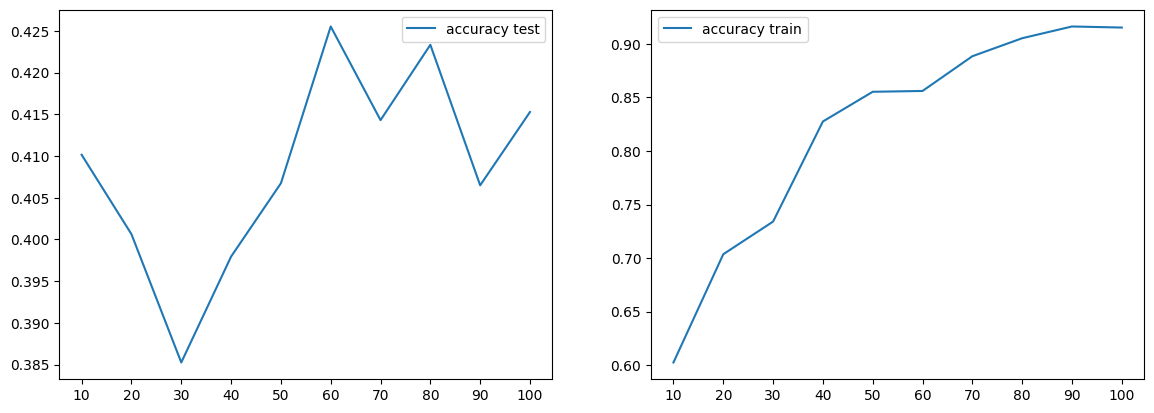

In [17]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(14)
ax[0].set_xticks(range(10), range(10, 101, 10))
ax[1].set_xticks(range(10), range(10, 101, 10))

ax[0].plot(acc_test, label = 'accuracy test')
ax[0].legend()
ax[1].plot(acc_train, label = 'accuracy train')
ax[1].legend()


## Метрики стабилизируются, возьмем модель с 60-й эпохи для обучения SVM

In [14]:
model.load_state_dict(torch.load('model_59.pth'))

<All keys matched successfully>

In [16]:
class MyDataset_no_aug(torch.utils.data.Dataset):
    def __init__(self, is_train = True):
        cond = train_cond if is_train else test_cond
        data_path = "./KTH_Dataset_tensors"
        self.data = []
        self.classes = []
        self.transforms = tv.transforms.Compose([lambda x: x.permute(2, 0, 1) / 255, tv.transforms.Grayscale(), tv.transforms.Resize((128, 128))])
    
        for directory in (os.listdir(data_path)):
            for video in tqdm(os.listdir(os.path.join(data_path, directory))):
                if cond(video) & (video.split('.')[0].split('_')[-1] <= '128'):
                    self.data.append(os.path.join(data_path, directory, video))
                    self.classes.append(classes_dict[directory])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, i):
        t = self.transforms(torch.load(self.data[i]))
        return t, self.classes[i]

In [17]:
train_no_aug = MyDataset_no_aug(True)

100%|████████████████████████████████████████████████████████████████████████| 65795/65795 [00:00<00:00, 461813.81it/s]


In [18]:
trainloader = torch.utils.data.DataLoader(train_no_aug, batch_size = 32)

In [19]:
model.to(device);

In [20]:
data = np.zeros((1, 8))

In [21]:
data

array([[0., 0., 0., 0., 0., 0., 0., 0.]])

In [22]:
i = 0
for inputs, labels in tqdm(trainloader):
    inputs = inputs.squeeze(0).to(device)
    labels = labels.unsqueeze(1).to(device)
    outputs = model(inputs).squeeze(0)
    data = np.concatenate([data, torch.cat((outputs, labels, outputs.argmax(dim = 1).unsqueeze(1)), dim = 1).cpu().detach().numpy()])

100%|████████████████████████████████████████████████████████████████████████████████| 530/530 [01:51<00:00,  4.74it/s]


In [26]:
train_df = pd.DataFrame(data[1:], columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'label', 'pred'])

In [27]:
data_test = np.zeros((1, 8))

In [28]:
i = 0
for inputs, labels in tqdm(testloader):
    inputs = inputs.squeeze(0).to(device)
    labels = labels.unsqueeze(1).to(device)
    outputs = model(inputs).squeeze(0)
    data_test = np.concatenate([data_test, torch.cat((outputs, labels, outputs.argmax(dim = 1).unsqueeze(1)), dim = 1).cpu().detach().numpy()])

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [01:09<00:00,  1.85it/s]


In [29]:
test_df = pd.DataFrame(data_test[1:], columns = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'label', 'pred'])

In [34]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')